# MATH7502 PROJECT: Principal Component Analysis (PCA) in Julia

### Alex White -- 43218307 

## Introduction
This notebook demonstrates the application of Principal Component Analysis (PCA) in Julia. PCA is a dimensionality reduction technique that helps simplify high-dimensional data by projecting it onto a lower-dimensional space, while retaining the most important features of the data. 

Using an example dataset, we will try to reduce the dimensionality of the data, to reduce noise within the dataset and allow influencing variables to be highlighted. 


## Key Concepts
PCA is used to identify the directions (principal components) in which the variance of the data is maximised. 

The steps used in PCA are as follows:
1. Center the data by subtracting the mean of each variable. We also divide by the standard deviation to make the std dev of each variable = 1.
2. Compute the covariance matrix of the centered data.
3. Perform eigenvalue decomposition on the covariance matrix to find the principal components.
4. Project the data onto the new principal component axes.


## Example Situation

Using the Breast Cancer Wisconsin dataset, we want to try to reduce the dimensionality of the dataset to find the factors that best predict cancerous outcomes. This would be an example of noise reduction.

The Breast Cancer Wisconsin dataset contains features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. This is accompanied by a classifier of benign or malignant, signified by B or M, for each record. There is 357 benign and 212 malignant records in the dataset.

First we make sure we have all the right packages installed.

In [13]:
# Packages
using Pkg, LinearAlgebra, Random, Plots, CSV, DataFrames, CategoricalArrays, Statistics, StatsBase, StatsPlots, DataFrames

Now we can import the data from the web source, and check it downloaded correctly.

In [14]:
# URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Load the dataset
df = CSV.File(download(url), header=false) |> DataFrame

# Preview the first few rows
first(df, 5)


5×32 DataFrame
 Row │ Column1   Column2  Column3  Column4  Column5  Column6  Column7  Column8 ⋯
     │ Int64     String1  Float64  Float64  Float64  Float64  Float64  Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   842302  M          17.99    10.38   122.8    1001.0  0.1184   0.2776  ⋯
   2 │   842517  M          20.57    17.77   132.9    1326.0  0.08474  0.07864
   3 │ 84300903  M          19.69    21.25   130.0    1203.0  0.1096   0.1599
   4 │ 84348301  M          11.42    20.38    77.58    386.1  0.1425   0.2839
   5 │ 84358402  M          20.29    14.34   135.1    1297.0  0.1003   0.1328  ⋯
                                                              24 columns omitted

As the data was downloaded without column names, we'll add these back, to help with usability.

In [15]:
# Define column names
col_names = ["ID", "Diagnosis", "Radius Mean", "Texture Mean", "Perimeter Mean", "Area Mean",
    "Smoothness Mean", "Compactness Mean", "Concavity Mean", "Concave Points Mean",
    "Symmetry Mean", "Fractal Dimension Mean", "Radius SE", "Texture SE", "Perimeter SE",
    "Area SE", "Smoothness SE", "Compactness SE", "Concavity SE", "Concave Points SE",
    "Symmetry SE", "Fractal Dimension SE", "Radius Worst", "Texture Worst", "Perimeter Worst",
    "Area Worst", "Smoothness Worst", "Compactness Worst", "Concavity Worst",
    "Concave Points Worst", "Symmetry Worst", "Fractal Dimension Worst"]
 
# Check the number of columns in the DataFrame
println("Number of columns in dataframe: ", ncol(df))
println("Number of column names provided: ", length(col_names))

# Assign column names to the DataFrame
rename!(df, Symbol.(col_names))

# Remove the ID column
select!(df, Not(:ID))

# View the dataset
first(df, 5)


Number of columns in dataframe: 32
Number of column names provided: 32


5×31 DataFrame
 Row │ Diagnosis  Radius Mean  Texture Mean  Perimeter Mean  Area Mean  Smooth ⋯
     │ String1    Float64      Float64       Float64         Float64    Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ M                17.99         10.38          122.8      1001.0         ⋯
   2 │ M                20.57         17.77          132.9      1326.0
   3 │ M                19.69         21.25          130.0      1203.0
   4 │ M                11.42         20.38           77.58      386.1
   5 │ M                20.29         14.34          135.1      1297.0         ⋯
                                                              26 columns omitted

In [16]:
# Convert the Diagnosis column to a categorical variable
df.Diagnosis = categorical(df.Diagnosis);

### Standardising the data
We need to standardise the data. We do this by subtracting the mean of each variable from the dataset to centre the data around the origin, and divide by the standard devation: 

$$
X_i' = \frac{X_i - \mu_i}{\sigma_i}
$$

where $ \mu_i $ is the mean of feature $ X_i $ and $ \sigma_i $ is its standard deviation.

This results in variables with a mean of zero, and a standard deviation of 1 which is essential for calculating the covariance matrix correctly.

We need to only use the numerical data (not the diagnosis) in the model so we do this as follows.

In [17]:
# Get the numerical columns
numerical_cols = [Symbol(col) for col in names(df) if eltype(df[!, col]) <: Number]

# Standardize the data for each numerical column (subtract mean and divide by standard deviation)
for col in numerical_cols
    df[!, col] = (df[!, col] .- mean(df[!, col])) ./ std(df[!, col])
end


### Computing the Covariance
We now want to compute the covariance of the centered matrix. The covariance matrix will show how each of the features are correlated with one another.

Positive values indicate that the features are positively correlated, and negative values mean they are inversly correlated. A value of 0 shows no correlation.

The covariance matrix $ \mathbf{C} $ is computed as follows:

$$
\mathbf{C} = \frac{1}{n-1} \mathbf{X}^T \mathbf{X}
$$

where $ \mathbf{X} $ is the standardized data matrix.


In [18]:
cov_matrix = cov(Matrix(df[:, numerical_cols])) # Only using the numerical columns

30×30 Matrix{Float64}:
  1.0          0.323782    0.997855   …  0.744214  0.163953  0.00706589
  0.323782     1.0         0.329533      0.295316  0.105008  0.119205
  0.997855     0.329533    1.0           0.771241  0.189115  0.0510185
  0.987357     0.321086    0.986507      0.722017  0.14357   0.0037376
  0.170581    -0.0233885   0.207278      0.503053  0.394309  0.499316
  0.506124     0.236702    0.556936   …  0.815573  0.510223  0.687382
  0.676764     0.302418    0.716136      0.861323  0.409464  0.51493
  0.822529     0.293464    0.850977      0.910155  0.375744  0.368661
  0.147741     0.071401    0.183027      0.430297  0.699826  0.438413
 -0.311631    -0.0764372  -0.261477      0.175325  0.334019  0.767297
  ⋮                                   ⋱                      
  0.297008     0.912045    0.303038      0.359755  0.233027  0.219122
  0.965137     0.35804     0.970387      0.816322  0.269493  0.138957
  0.941082     0.343546    0.94155       0.747419  0.209146  0.079647
  

### Eigenvector and eigenvalue decomposition
Using the covariance, we can find the eigenvectors and eigenvalues, which represent the direction and magnitude of most variance, respectively. These, when sorted by eigenvalue magnitude, will give us our Principal Components, and allow us to complete the noise reduction of the dataset. 

In [19]:
# Perform eigenvalue decomposition
eig_vals, eig_vecs = eigen(cov_matrix)
eig_vals_sorted_idx = sortperm(eig_vals, rev=true)
eig_vals = eig_vals[eig_vals_sorted_idx]
eig_vecs = eig_vecs[:, eig_vals_sorted_idx]

30×30 Matrix{Float64}:
 -0.218902   -0.233857     0.00853124  …   0.21146      0.702414
 -0.103725   -0.0597061   -0.0645499      -0.0105339    0.000273661
 -0.227537   -0.215181     0.00931422      0.383826    -0.689897
 -0.220995   -0.231077    -0.0286995      -0.422795    -0.0329473
 -0.14259     0.186113     0.104292       -0.00343467  -0.00484746
 -0.239285    0.151892     0.0740916   …  -0.0410168    0.0446742
 -0.2584      0.0601654   -0.00273384     -0.0100148    0.0251387
 -0.260854   -0.0347675    0.0255635      -0.00420695  -0.00107727
 -0.138167    0.190349     0.0402399      -0.00756986  -0.00128038
 -0.0643633   0.366575     0.0225741       0.00730143  -0.00475568
  ⋮                                    ⋱               
 -0.104469   -0.0454673    0.0422978       0.0172355    0.00102054
 -0.23664    -0.199878     0.0485465       0.0229218    0.0797439
 -0.224871   -0.219352     0.0119023       0.444936     0.0397423
 -0.127953    0.172304     0.259798        0.00738549   0.

### Choosing how many components to keep
We want to only choose to keep the eigenvalues that explain the majority of the variance. There are a few different ways to do this, such as using subject-area knowledge, putting a limit of 1, or judging based off a scree plot. We will choose the latter. 

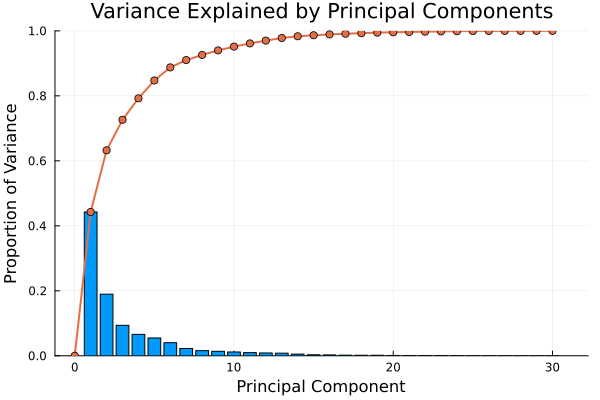

In [20]:
# Calculate the explained variance and cumulative variance
explained_variance = eig_vals / sum(eig_vals)
cumulative_variance = cumsum(explained_variance)

# Prepend a 0 to the cumulative variance to make the plot start from 0
cumulative_variance = [0; cumulative_variance]

# Create the scree plot showing the proportion of variance explained by each PC
plot(1:length(explained_variance), explained_variance, seriestype=:bar, xlabel="Principal Component", ylabel="Proportion of Variance", title="Variance Explained by Principal Components", legend=false)

# Overlay the cumulative variance line on the same plot, starting at 0
plot!(0:length(cumulative_variance)-1, cumulative_variance, seriestype=:line, lw=2, marker=:circle, label="Cumulative Variance")


The bar chart displays the proportion of variance explained by each principal component (PC), showing how much of the data's variability is captured by each PC. The cumulative variance line indicates the total variance captured as more PCs are included. From the chart, we can see that the line starts to plateau around the 7th PC. This indicates that the first 7 PCs account for the majority of the variance, making them useful for dimensionality reduction while retaining most of the dataset's information. Thus, for use of the noise-reduced data, it is suggested to use the first 7 PCs. 

We can also see from the chart that the first principal component explains almost half the variation in the dataset, and there is somewhat of an exponential decrease after that. This shows that with more principal components, there are diminishing returns. 

### Projection onto the data
The next step is projecting the data onto the principal components. 

In [21]:
# Project the data onto the principal components
df_PCA = Matrix(df[:, numerical_cols]) * eig_vecs[:, 1:7]

# Convert the projected data to a DataFrame
df_PCA = DataFrame(df_PCA, :auto)

# Add Diagnosis column to the PCA DataFrame
df_PCA.Diagnosis = df.Diagnosis

569-element CategoricalArray{String1,1,UInt32}:
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 ⋮
 String1("B")
 String1("B")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("M")
 String1("B")

Here we have the noise reduced dataset, that we've obtained using PCA. We can use this for data visualisation to see trends, or for further analysis. 

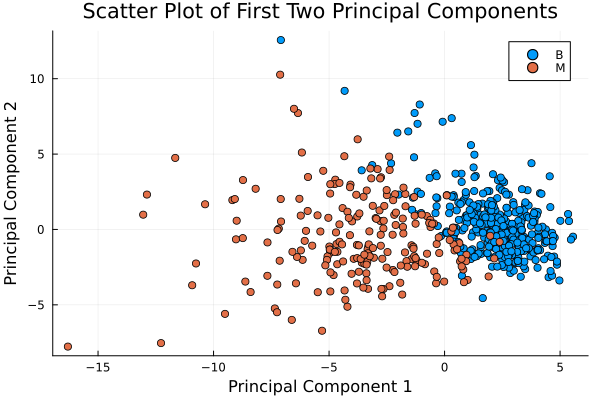

In [22]:
# Visualize the projection using a scatter plot of the first two principal components

# Extract the first two principal components for visualization
df_PCA_2 = df_PCA[:, 1:2]

# Add Diagnosis column to the DataFrame for grouping
df_PCA_2.Diagnosis = df_PCA.Diagnosis

# Plot the first two principal components
@df df_PCA_2 scatter(
    :x1, :x2,
    group=:Diagnosis,
    xlabel="Principal Component 1",
    ylabel="Principal Component 2",
    title="Scatter Plot of First Two Principal Components",
    legend=:topright,
    marker=:circle
)


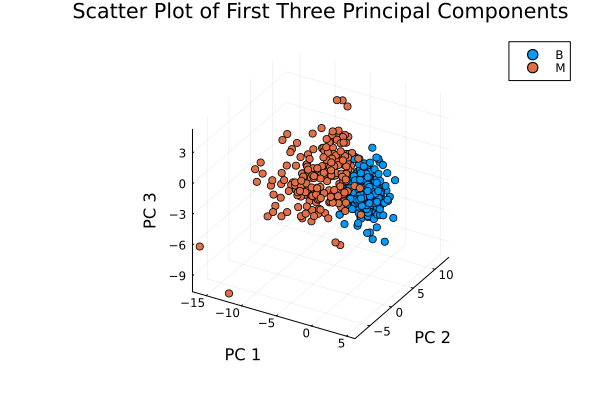

In [23]:
# Visualise the first three principal components

# Extract the first three principal components for visualization
df_PCA_3 = df_PCA[:, 1:3]

# Add Diagnosis column to the DataFrame for grouping
df_PCA_3.Diagnosis = df_PCA.Diagnosis

# Plot the first three principal components
@df df_PCA_3 scatter(
    :x1, :x2, :x3,
    group=:Diagnosis,
    xlabel="PC 1",
    ylabel="PC 2",
    zlabel="PC 3",
    title="Scatter Plot of First Three Principal Components",
    legend=:topright,
    marker=:circle
)

PCA transforms the data into a new coordinate system where each axis corresponds to a principal component. In this visualization, we observe a clear distinction between the benign and malignant cases. The benign data points tend to cluster together, indicating that they share similar characteristics that are well captured by the first few principal components. On the other hand, the malignant data is more spread out, reflecting greater variability in these cases. This separation in the PCA space suggests that the principal components effectively capture the key differences between the two groups, aiding in their differentiation.


## Conclusion

Principal Component Analysis (PCA) is a powerful tool for reducing the dimensionality of high-dimensional datasets while preserving the most important features. In this analysis of the Breast Cancer Wisconsin dataset, we demonstrated how PCA can transform the original data into a set of orthogonal principal components, ordered by the amount of variance they explain.

From the **scree plot**, we observed that the first few principal components capture a significant portion of the variance in the data, suggesting that we can reduce the number of dimensions without losing much information. By projecting the data onto the first three principal components, we were able to visualize the dataset in 3D space, which helps to distinguish between benign and malignant diagnoses.

In summary, PCA is a valuable technique for dimensionality reduction, data visualization, and noise reduction, and it serves as an essential preprocessing step in many machine learning workflows. By applying PCA, we can enhance the interpretability of data, speed up algorithms, and maintain data integrity even when dealing with complex, high-dimensional datasets.
